<a href="https://colab.research.google.com/github/florinOK/amr/blob/colab/vae-mnist/vae-mnist.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

https://www.tensorflow.org/tutorials/generative/cvae

In [1]:
# to generate gifs
! pip install -q imageio
! pip install -q tensorflow-probability
! pip install -q git+https://github.com/tensorflow/docs

In [2]:
import glob
import time
import imageio

import PIL

import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import tensorflow_probability as tfp

import matplotlib.pyplot as plt

from IPython import display

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.mnist.load_data()

In [4]:
def preprocess_images(images):
  images = images.reshape((images.shape[0], 28, 28, 1)) / 255.
  return np.where(images > .5, 1.0, 0.0).astype('float32')


train_images = preprocess_images(train_images)
test_images = preprocess_images(test_images)

In [5]:
train_images.shape, train_labels.shape

((60000, 28, 28, 1), (60000,))

In [6]:
batch_size = 32

train_size = 60000
test_size = 10000


train_dataset = (
    tf.data.Dataset.from_tensor_slices(train_images)
    .shuffle(train_size)
    .batch(batch_size)
)
test_dataset = (
    tf.data.Dataset.from_tensor_slices(test_images)
    .shuffle(test_size)
    .batch(batch_size)
)

In [7]:
class CVAE(tf.keras.Model):
    """Convolutional variational autoencoder."""

    def __init__(self, latent_dim):
        super(CVAE, self).__init__()
        self.latent_dim = latent_dim

        self.encoder = tf.keras.Sequential(
            [
                tf.keras.layers.InputLayer(input_shape=(28, 28, 1)),
                tf.keras.layers.Conv2D(
                    filters=32, kernel_size=3, strides=(2, 2), activation='relu'
                ),
                tf.keras.layers.Conv2D(
                    filters=64, kernel_size=3, strides=(2, 2), activation='relu'
                ),
                tf.keras.layers.Flatten(),
                # No activation
                tf.keras.layers.Dense(latent_dim + latent_dim),
            ]
        )

        self.decoder = tf.keras.Sequential(
            [
                tf.keras.layers.InputLayer(input_shape=(latent_dim,)),
                tf.keras.layers.Dense(units=7*7*32, activation=tf.nn.relu),
                tf.keras.layers.Reshape(target_shape=(7, 7, 32)),
                tf.keras.layers.Conv2DTranspose(
                    filters=64, kernel_size=3, strides=2, padding='same', activation='relu'
                ),
                tf.keras.layers.Conv2DTranspose(
                    filters=32, kernel_size=3, strides=2, padding='same', activation='relu'
                ),
                # No activation
                tf.keras.layers.Conv2DTranspose(
                    filters=1, kernel_size=3, strides=1, padding='same'
                ),
            ]
        )

    @tf.function
    def sample(self, eps=None):
        if eps is None:
            eps = tf.random.normal(shape=(100, self.latent_dim))
        return self.decode(eps, apply_sigmoid=True)

    def encode(self, x):
        mean, log_variance = tf.split(self.encoder(x), num_or_size_splits=2, axis=1)
        return mean, log_variance

    def reparameterize(self, mean, log_variance):
        eps = tf.random.normal(shape=mean.shape)
        return eps * tf.exp(log_variance * .5) + mean

    def decode(self, z, apply_sigmoid=False):
        logits = self.decoder(z)
        if apply_sigmoid:
            probs = tf.sigmoid(logits)
            return probs
        return logits


In [8]:
optimizer = tf.keras.optimizers.Adam(1e-4)


def log_normal_pdf(sample, mean, log_variance, raxis=1):
    log_2pi = tf.math.log(2. * np.pi)
    return tf.reduce_sum(-0.5 * ((sample - mean) ** 2. * tf.exp(-log_variance) + log_variance + log_2pi), axis=raxis)


def compute_loss(model, x):
    mean, log_variance = model.encode(x)
    z = model.reparameterize(mean, log_variance)

    x_logits = model.decode(z)
    cross_entropy = tf.nn.sigmoid_cross_entropy_with_logits(logits=x_logits, labels=x)

    log_px_z = -tf.reduce_sum(cross_entropy, axis=[1, 2, 3])
    log_pz = log_normal_pdf(z, 0., 0.)
    log_qz_x = log_normal_pdf(z, mean, log_variance)
    return -tf.reduce_mean(log_px_z + log_pz - log_qz_x)


@tf.function
def train_step(model, x, optimizer):
    """Executes one training step and returns the loss.

    This function computes the loss and gradients, and uses the latter to
    update the model's parameters.
    """
    with tf.GradientTape() as tape:
        loss = compute_loss(model, x)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))


In [9]:
epochs = 10
# set the dimensionality of the latent space to a plane for visualization
latent_dim = 2
num_examples_to_generate = 16

# keeping the random vector constant for generation (prediction) so
# it will be easier to see the improvement.
random_vector_for_generation = tf.random.normal(shape=[num_examples_to_generate, latent_dim])

model = CVAE(latent_dim)

In [10]:
def plot_original_images(test_sample):
    fig = plt.figure(figsize=(4, 4))
    for i in range(test_sample.shape[0]):
        plt.subplot(4, 4, i + 1)
        plt.imshow(test_sample[i, :, :, 0], cmap='gray')
        plt.axis('off')
    plt.show()


def generate_and_save_images(model, epoch, test_sample):
    mean, logvar = model.encode(test_sample)
    z = model.reparameterize(mean, logvar)
    predictions = model.sample(z)
    fig = plt.figure(figsize=(4, 4))

    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i + 1)
        plt.imshow(predictions[i, :, :, 0], cmap='gray')
        plt.axis('off')

    # tight_layout minimizes the overlap between 2 sub-plots
    plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()


In [11]:
# Pick a sample of the test set for generating output images
assert batch_size >= num_examples_to_generate
for test_batch in test_dataset.take(1):
    test_sample = test_batch[0:num_examples_to_generate, :, :, :]


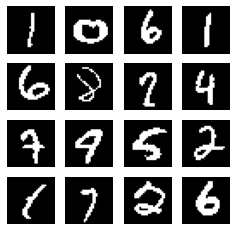

In [12]:
plot_original_images(test_sample)

Epoch: 10, Test set ELBO: -157.16578674316406, time elapse for current epoch: 8.5126211643219


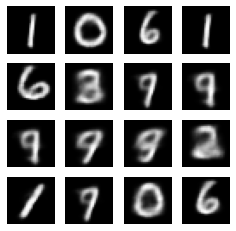

In [13]:
generate_and_save_images(model, 0, test_sample)


for epoch in range(1, epochs + 1):
    start_time = time.time()
    for train_x in train_dataset:
        train_step(model, train_x, optimizer)
    end_time = time.time()

    loss = tf.keras.metrics.Mean()
    for test_x in test_dataset:
        loss(compute_loss(model, test_x))
    
    elbo = -loss.result()
    display.clear_output(wait=False)

    print(f'Epoch: {epoch}, Test set ELBO: {elbo}, time elapse for current epoch: {end_time - start_time}')
    generate_and_save_images(model, epoch, test_sample)


### Display an animated GIF of all the saved images

(-0.5, 287.5, 287.5, -0.5)

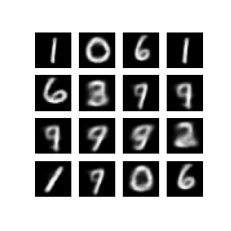

In [14]:
def display_image(epoch_no):
    return PIL.Image.open(f'image_at_epoch_{epoch_no:04d}.png')


plt.imshow(display_image(epoch))
plt.axis('off')  # Display images

In [15]:
anim_file = 'cvae.gif'


with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob.glob('image*.png')
    filenames = sorted(filenames)

    for filename in filenames:
        image = imageio.imread(filename)
        writer.append_data(image)
    
    image = imageio.imread(filename)
    writer.append_data(image)



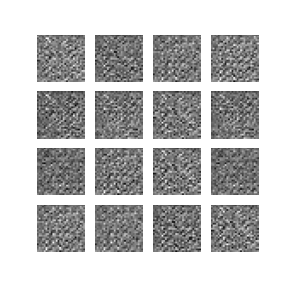

In [17]:
import tensorflow_docs.vis.embed as embed


embed.embed_file(anim_file)

### Display a 2D manifold of digits from the latent space

In [18]:
def plot_latent_images(model, n, digit_size=28):
    """Plots n x n digit images decoded from the latent space."""

    norm = tfp.distributions.Normal(0, 1)
    grid_x = norm.quantile(np.linspace(0.05, 0.95, n))
    grid_y = norm.quantile(np.linspace(0.05, 0.95, n))
    
    image_width = digit_size * n
    image_height = image_width
    image = np.zeros((image_height, image_width))

    for i, yi in enumerate(grid_x):
        for j, xi in enumerate(grid_y):
            z = np.array([[xi, yi]])
            x_decoded = model.sample(z)
            digit = tf.reshape(x_decoded[0], (digit_size, digit_size))
            image[
                i * digit_size: (i + 1) * digit_size,
                j * digit_size: (j + 1) * digit_size
            ] = digit.numpy()

    plt.figure(figsize=(10, 10))
    plt.imshow(image, cmap='Greys_r')
    plt.axis('Off')
    plt.show()


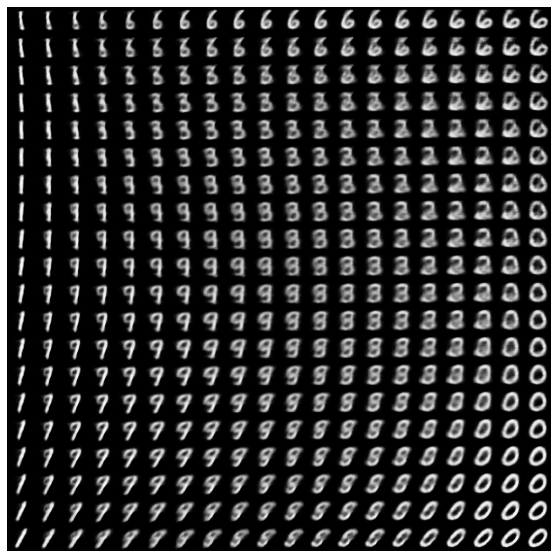

In [19]:
plot_latent_images(model, 20)